In [1]:
# %pip install pettingzoo
# %pip install pettingzoo[classic] --no-deps
# %pip install chess

In [2]:
# %pip install ray dm-tree

In [3]:
# %pip install lz4 "ray[tune]" tensorboardX

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import ray.rllib.algorithms.ppo as ppo
import torch
import torch.nn as nn

from pettingzoo.test import api_test
from pettingzoo.classic import chess_v6
from pettingzoo.utils.env_logger import EnvLogger
from ray.tune.registry import register_env
from ray.rllib.env.wrappers.pettingzoo_env import PettingZooEnv
from ray.rllib.utils.metrics import (
    ENV_RUNNER_RESULTS,
    EPISODE_RETURN_MEAN,
    EPISODE_LEN_MEAN
)
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.utils.typing import ModelConfigDict
from tqdm import trange

In [6]:
import logging
logging.getLogger("ray").setLevel(logging.ERROR)
logging.getLogger("ray.rllib").setLevel(logging.ERROR)

## Environment

In [7]:
EnvLogger.suppress_output()

https://pettingzoo.farama.org/environments/classic/chess/

Termination Conditions (when rewards are given). The game ends and rewards are assigned when:

- Checkmate - winning player gets +1, losing player gets -1
- Stalemate - both players get 0
- Insufficient material (e.g., king vs king) - both get 0
- 50-move rule - both get 0
- Threefold repetition - both get 0
- Resignation (if implemented) - resigning player loses

In [8]:
env = chess_v6.env()

In [9]:
api_test(env, num_cycles=1_000, verbose_progress=False)

Starting API test
Passed API test


In [10]:
# env = chess_v6.env(render_mode="human")
# env.reset(seed=42)

# for agent in env.agent_iter():

#     observation, reward, terminated, truncated, _ = env.last()

#     if terminated or truncated:
#         action = None
#     else:
#         mask = observation["action_mask"]
#         action = env.action_space(agent).sample(mask)
#         print(action)

#     env.step(action)
#     # time.sleep(10)

In [11]:
# env.close()

## Model

In [12]:
class ChessModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        # Chess observation has shape: (8, 8, 111) = 7104 values
        # Action mask has shape: (4672,)

        # Process board observation with CNN
        self.conv = nn.Sequential(
            nn.Conv2d(111, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Calculate CNN output size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 111, 8, 8)
            cnn_out = self.conv(dummy_input)
            cnn_output_size = cnn_out.shape[1]

        # Combine with action mask
        self.fc = nn.Sequential(
            nn.Linear(cnn_output_size + 4672, 512),  # CNN output + action mask
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_outputs),
        )

        # Value branch
        self.value_branch = nn.Sequential(
            nn.Linear(cnn_output_size + 4672, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, input_dict, state, seq_lens):
        # Extract observation and action_mask
        obs = input_dict["obs"]

        # Check if it's a dict or already separated
        if isinstance(obs, dict):
            board = obs["observation"]  # Shape: (batch, 8, 8, 111)
            action_mask = obs["action_mask"]  # Shape: (batch, 4672)
        else:
            # Assume obs is the board only
            board = obs
            action_mask = None

        # Convert board to channel-first format
        board = board.permute(0, 3, 1, 2)  # (batch, 111, 8, 8)

        # Process through CNN
        cnn_out = self.conv(board)

        # Combine with action mask if available
        if action_mask is not None:
            combined = torch.cat([cnn_out, action_mask], dim=1)
        else:
            combined = cnn_out

        # Get logits
        logits = self.fc(combined)

        # Mask out illegal moves
        if action_mask is not None:
            # Convert action_mask to the same dtype as logits
            action_mask = action_mask.to(logits.dtype)
            logits = logits + (1.0 - action_mask) * (-1e10)

        # Get value
        self._value_out = self.value_branch(combined).squeeze(-1)

        return logits, state

    def value_function(self):
        return self._value_out

# Register the custom model
ModelCatalog.register_custom_model("chess_model", ChessModel)

In [13]:
ray.init(ignore_reinit_error=True, logging_level="error")

Python version:,3.12.12
Ray version:,2.53.0


In [14]:
register_env(
    "chess",
    lambda cfg: PettingZooEnv(chess_v6.env()),
)

In [15]:
suggested_workers = 1

if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()

In [16]:
config = ppo.PPOConfig()

config = (
    config.environment("chess", env_config={})
    .framework(framework="torch")
    .training(
        model={
            "custom_model": "chess_model",
            "custom_model_config": {},
            "fcnet_hiddens": [],  # Disable default FC since we use custom
            "use_lstm": False,
        },
        lr=0.0001,  # Lower learning rate for chess
        train_batch_size=2048,
    )
    .debugging(log_level="ERROR")
    .resources(num_gpus=num_gpus)
    .env_runners(
        num_cpus_per_env_runner=1,
        num_env_runners=suggested_workers,
        rollout_fragment_length="auto",
    )
    .api_stack(
        enable_rl_module_and_learner=False,
        enable_env_runner_and_connector_v2=False
    )
    .multi_agent(
        policies=["player_0", "player_1"],
        policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: agent_id,
    )
)

In [17]:
trainer = config.build_algo()

(pid=10022) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=10022) E0000 00:00:1768370819.190759   10022 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=10022) E0000 00:00:1768370819.197065   10022 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=10022) W0000 00:00:1768370819.212981   10022 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=10022) W0000 00:00:1768370819.213016   10022 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=10022) W0000 00:00:1768370819.213019   10022 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid lin

In [18]:
num_episodes = 150

We should also add model pretraining to predict legal moves and fasten the training. Implementation steps:

- Interact with enironment randomly for N games to generate sample.
- Train torch model to predict legal moves based on state

In [23]:
episode_rewards_0 = []
episode_rewards_1 = []
episode_lengths = []

warnings.filterwarnings('ignore')

for i in trange(num_episodes):
    result = trainer.train()

    player_0_rewards = result[ENV_RUNNER_RESULTS]["hist_stats"]["policy_player_0_reward"]
    _, player_0_rewards = np.unique(player_0_rewards, return_counts=True)
    player_1_rewards = result[ENV_RUNNER_RESULTS]["hist_stats"]["policy_player_1_reward"]
    _, player_1_rewards = np.unique(player_1_rewards, return_counts=True)

    episode_rewards_0.append(player_0_rewards)
    episode_rewards_1.append(player_1_rewards)

    episode_lengths.append(result[ENV_RUNNER_RESULTS][EPISODE_LEN_MEAN])
    if i % 5 == 0 and i > 0:
        print(
            f"Epoch {i:.0f}: average moves {episode_lengths[-1]:.2f}; "
            f"P0 wins, Draws, P1 wins  {player_0_rewards}"
        )


  4%|▍         | 6/150 [03:39<1:27:06, 36.29s/it]

Epoch 5: average moves 347.02; P0 wins, Draws, P1 wins  [ 4 35  1]


  7%|▋         | 11/150 [06:48<1:27:06, 37.60s/it]

Epoch 10: average moves 349.11; P0 wins, Draws, P1 wins  [ 6 63  1]


 11%|█         | 16/150 [09:51<1:21:57, 36.70s/it]

Epoch 15: average moves 347.64; P0 wins, Draws, P1 wins  [ 8 87  5]


 14%|█▍        | 21/150 [12:50<1:17:09, 35.89s/it]

Epoch 20: average moves 341.52; P0 wins, Draws, P1 wins  [ 7 88  5]


 17%|█▋        | 26/150 [15:51<1:14:14, 35.93s/it]

Epoch 25: average moves 330.55; P0 wins, Draws, P1 wins  [ 6 86  8]


 21%|██        | 31/150 [18:53<1:12:09, 36.38s/it]

Epoch 30: average moves 330.29; P0 wins, Draws, P1 wins  [ 7 84  9]


 24%|██▍       | 36/150 [21:54<1:09:07, 36.38s/it]

Epoch 35: average moves 333.18; P0 wins, Draws, P1 wins  [ 5 86  9]


 27%|██▋       | 41/150 [24:56<1:05:58, 36.31s/it]

Epoch 40: average moves 337.62; P0 wins, Draws, P1 wins  [ 6 88  6]


 31%|███       | 46/150 [27:58<1:03:02, 36.37s/it]

Epoch 45: average moves 325.90; P0 wins, Draws, P1 wins  [ 8 87  5]


 34%|███▍      | 51/150 [31:00<59:44, 36.21s/it]  

Epoch 50: average moves 324.53; P0 wins, Draws, P1 wins  [10 85  5]


 37%|███▋      | 56/150 [34:01<56:30, 36.07s/it]

Epoch 55: average moves 320.42; P0 wins, Draws, P1 wins  [ 9 84  7]


 41%|████      | 61/150 [37:02<53:44, 36.23s/it]

Epoch 60: average moves 323.64; P0 wins, Draws, P1 wins  [ 7 82 11]


 44%|████▍     | 66/150 [40:03<50:48, 36.29s/it]

Epoch 65: average moves 323.67; P0 wins, Draws, P1 wins  [10 79 11]


 47%|████▋     | 71/150 [43:05<47:57, 36.42s/it]

Epoch 70: average moves 315.33; P0 wins, Draws, P1 wins  [11 78 11]


 51%|█████     | 76/150 [46:06<44:36, 36.16s/it]

Epoch 75: average moves 312.19; P0 wins, Draws, P1 wins  [11 82  7]


 54%|█████▍    | 81/150 [49:07<41:31, 36.12s/it]

Epoch 80: average moves 316.76; P0 wins, Draws, P1 wins  [ 8 86  6]


 57%|█████▋    | 86/150 [52:09<38:47, 36.36s/it]

Epoch 85: average moves 314.67; P0 wins, Draws, P1 wins  [ 8 83  9]


 61%|██████    | 91/150 [55:10<35:33, 36.16s/it]

Epoch 90: average moves 314.85; P0 wins, Draws, P1 wins  [ 8 83  9]


 64%|██████▍   | 96/150 [58:10<32:36, 36.24s/it]

Epoch 95: average moves 321.13; P0 wins, Draws, P1 wins  [11 81  8]


 67%|██████▋   | 101/150 [1:01:11<29:21, 35.94s/it]

Epoch 100: average moves 316.86; P0 wins, Draws, P1 wins  [12 82  6]


 71%|███████   | 106/150 [1:04:11<26:25, 36.04s/it]

Epoch 105: average moves 316.23; P0 wins, Draws, P1 wins  [12 83  5]


 74%|███████▍  | 111/150 [1:07:11<23:20, 35.92s/it]

Epoch 110: average moves 312.63; P0 wins, Draws, P1 wins  [11 80  9]


 77%|███████▋  | 116/150 [1:10:11<20:20, 35.90s/it]

Epoch 115: average moves 309.05; P0 wins, Draws, P1 wins  [10 79 11]


 81%|████████  | 121/150 [1:13:13<17:35, 36.41s/it]

Epoch 120: average moves 320.58; P0 wins, Draws, P1 wins  [10 81  9]


 84%|████████▍ | 126/150 [1:16:14<14:29, 36.23s/it]

Epoch 125: average moves 329.30; P0 wins, Draws, P1 wins  [11 82  7]


 87%|████████▋ | 131/150 [1:19:16<11:29, 36.27s/it]

Epoch 130: average moves 338.76; P0 wins, Draws, P1 wins  [ 8 83  9]


 91%|█████████ | 136/150 [1:22:15<08:23, 35.97s/it]

Epoch 135: average moves 339.52; P0 wins, Draws, P1 wins  [ 7 85  8]


 94%|█████████▍| 141/150 [1:25:15<05:22, 35.84s/it]

Epoch 140: average moves 328.45; P0 wins, Draws, P1 wins  [ 3 89  8]


 97%|█████████▋| 146/150 [1:28:19<02:26, 36.51s/it]

Epoch 145: average moves 327.79; P0 wins, Draws, P1 wins  [ 4 89  7]


100%|██████████| 150/150 [1:30:42<00:00, 36.29s/it]


Note 1:

Only fully finished episodes are counted above, thats why number of wins + draws + losses is increasing in the beginning. If someone makes an illegal move, game is stopped

Note 2:

A standard chess game averages around 40 full moves (80 half-moves), but this varies significantly by skill level and time control, with amateur games often ending sooner due to blunders (25-35 moves) and professional classical games sometimes extending to 50+ moves before a draw or mate.

If game is significantly longer - players are moving randomly

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
145,330.456
146,329.302
147,328.455
148,327.372


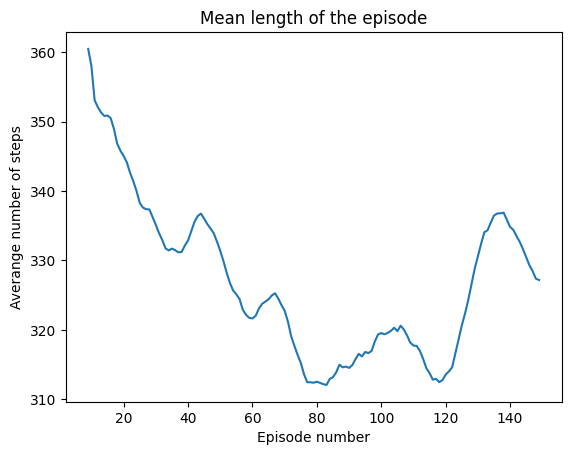

In [28]:
plt.plot(pd.DataFrame(episode_lengths).rolling(10).mean())
plt.ylabel("Averange number of steps")
plt.xlabel("Episode number")
plt.title("Mean length of the episode")
plt.show()

In [34]:
rewards_table = (
    pd.DataFrame(episode_rewards_0)
    .rolling(10)
    .mean()
    .iloc[:, [0, 2]]
)

rewards_table.columns = ["Player 1", "Player 2"]

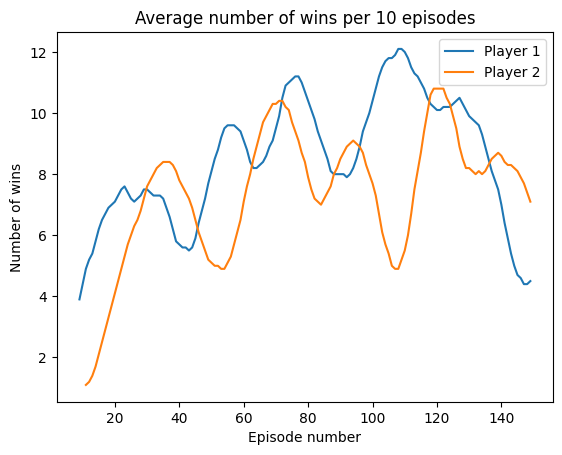

In [35]:
rewards_table.plot()
plt.ylabel("Number of wins")
plt.xlabel("Episode number")
plt.title("Average number of wins per 10 episodes")
plt.show()

In [ ]:
# todo: comparison of trained agents vs random player